In [ ]:
!git clone https://github.com/kelvis24/cell-counting.git

Cloning into 'cell-counting'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!unzip /content/IDCIAv2.zip

Archive:  /content/IDCIAv2.zip
   creating: IDCIA v2/
  inflating: IDCIA v2/.DS_Store      
  inflating: __MACOSX/IDCIA v2/._.DS_Store  
   creating: IDCIA v2/images/
   creating: IDCIA v2/ground_truth/
  inflating: IDCIA v2/images/220912_GFP-AHPC_B_TuJ1_F5_DAPI_ND1_20x.tiff  
  inflating: __MACOSX/IDCIA v2/images/._220912_GFP-AHPC_B_TuJ1_F5_DAPI_ND1_20x.tiff  
  inflating: IDCIA v2/images/220816_GFP-AHPC_D_RIP_F2_DAPI_ND1_20x.tiff  
  inflating: __MACOSX/IDCIA v2/images/._220816_GFP-AHPC_D_RIP_F2_DAPI_ND1_20x.tiff  
  inflating: IDCIA v2/images/220815_GFP-AHPC_B_TuJ1_F10_DAPI_ND1_20x.tiff  
  inflating: __MACOSX/IDCIA v2/images/._220815_GFP-AHPC_B_TuJ1_F10_DAPI_ND1_20x.tiff  
  inflating: IDCIA v2/images/220815_GFP-AHPC_D_Ki67_F1_DAPI_ND1_20x.tiff  
  inflating: __MACOSX/IDCIA v2/images/._220815_GFP-AHPC_D_Ki67_F1_DAPI_ND1_20x.tiff  
  inflating: IDCIA v2/images/220815_GFP-AHPC_A_MAP2ab_F3_DAPI_ND1_20x.tiff  
  inflating: __MACOSX/IDCIA v2/images/._220815_GFP-AHPC_A_MAP2ab_F3_DAPI_ND1

In [ ]:

import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split




In [ ]:
class IDCIAv2(Dataset):
    def __init__(self, image_files, csv_files, transform=None):
        self.image_files = image_files
        self.csv_files = csv_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        csv_path = self.csv_files[idx]


        image = imread(image_path)
        # Read the csv file and get the number of cells in the image
        ground_truth = pd.read_csv(csv_path)
        cell_count = ground_truth.shape[0]

        if self.transform:
            image = self.transform(image)

        return image, cell_count

# Data preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
import csv
import random

# Load image and CSV file paths
image_dir = '/content/IDCIAv2/images'
csv_dir = '/content/IDCIAv2/ground_truth'

count_dict = {}
image_files = [file for file in os.listdir(image_dir) if file.endswith('.tiff')]

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)

    # Assuming CSV files have the same name as image files but with a different extension
    csv_file_path = os.path.join(csv_dir, f"{os.path.splitext(image_file)[0]}.csv")

    # Get the cell_count of each file
    with open(csv_file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        row_count = sum(1 for row in csv_reader) - 1
        count_dict[image_file] = row_count

# Sort count_dict by counts in ascending order
sorted_counts = sorted(count_dict.items(), key=lambda x: x[1], reverse = False)
sorted_images = [ image [0] for image in sorted_counts]
print (sorted_counts)
print (sorted_images)

# Assign weights based on the rank of counts
weights = {}
for rank, (image_file, _) in enumerate(sorted_counts):
    weights[image_file] = rank + 1  # Adding 1 to avoid zero weight
    #print(weights)
total_weight = sum(weights.values())

# Assign the probability based on the normalized weight to the image files
probabilities = [weight / total_weight for weight in weights.values()]
print (probabilities)

# Selecting the number_of_images
number_of_images = 150
total_file_indicies = list (range(len(sorted_counts)))
chosen = []
Add_element = True
final_image_list = []

i = 0
while (Add_element):
  i = i + 1
  chosen_index = random.choices(total_file_indicies, probabilities, k = 1)[0]
  if chosen_index not in chosen:
    chosen.append(chosen_index)
    final_image_list.append(sorted_images[chosen_index])
  if len(final_image_list) == number_of_images:
    Add_element = False

print("Steps taken for selecting images: ", i)
print("total number of files chosen" , len (final_image_list))
print("Final Image List:", final_image_list)

[('220909_GFP-AHPC_D_MAP2ab_F4_DAPI_ND1_20x.tiff', 0), ('220815_GFP-AHPC_D_MAP2ab_F4_DAPI_ND1_20x.tiff', 8), ('220912_GFP-AHPC_B_Nestin_F8_DAPI_ND1_20x.tiff', 9), ('220815_GFP-AHPC_D_MAP2ab_F6_DAPI_ND1_20x.tiff', 10), ('220909_GFP-AHPC_B_Ki67_F3_DAPI_ND1_20x.tiff', 10), ('220912_GFP-AHPC_B_Nestin_F9_DAPI_ND1_20x.tiff', 10), ('220912_GFP-AHPC_C_Map2AB_F5_DAPI_ND1_20x.tiff', 11), ('220912_GFP-AHPC_C_Map2AB_F7_DAPI_ND1_20x.tiff', 12), ('220815_GFP-AHPC_A_TuJ1_F3_DAPI_ND1_20x.tiff', 12), ('220815_GFP-AHPC_D_MAP2ab_F10_DAPI_ND1_20x.tiff', 12), ('220815_GFP-AHPC_D_MAP2ab_F8_DAPI_ND1_20x.tiff', 13), ('220815_GFP-AHPC_C_Ki67_F7_DAPI_ND1_20x.tiff', 14), ('220815_GFP-AHPC_C_Ki67_F8_DAPI_ND1_20x.tiff', 14), ('220815_GFP-AHPC_C_TuJ1_F7_DAPI_ND1_20x.tiff', 15), ('220909_GFP-AHPC_C_Nestin_F8_DAPI_ND1_20x.tiff', 15), ('220815_GFP-AHPC_C_Ki67_F4_DAPI_ND1_20x.tiff', 16), ('220815_GFP-AHPC_A_Ki67_F1_DAPI_ND1_20x.tiff', 16), ('220912_GFP-AHPC_C_Map2AB_F2_DAPI_ND1_20x.tiff', 17), ('220815_GFP-AHPC_C_Ki67_

In [ ]:
final_image_files = [os.path.join(image_dir, filename) for filename in final_image_list]
final_csv_files = [os.path.join(csv_dir, filename.replace('.tiff', '.csv')) for filename in final_image_list]

# Split data into train, validation, and test sets
train_files, test_files, train_csv, test_csv = train_test_split(final_image_files, final_csv_files, test_size=0.3, random_state=42)
val_files, test_files, val_csv, test_csv = train_test_split(test_files, test_csv, test_size=0.5, random_state=42)

# Create instances of the dataset for training, validation, and testing
train_dataset = IDCIAv2(image_files=train_files, csv_files=train_csv, transform=transform)
val_dataset = IDCIAv2(image_files=val_files, csv_files=val_csv, transform=transform)
test_dataset = IDCIAv2(image_files=test_files, csv_files=test_csv, transform=transform)


# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Statistics of datasets
train_cell_counts = [sample[1] for sample in train_dataset]
val_cell_counts = [sample[1] for sample in val_dataset]
test_cell_counts = [sample[1] for sample in test_dataset]

# Calculate statistics
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)
num_test_images = len(test_dataset)

mean_train_cells_per_image = np.mean(train_cell_counts)
std_train_cells_per_image = np.std(train_cell_counts)

mean_val_cells_per_image = np.mean(val_cell_counts)
std_val_cells_per_image = np.std(val_cell_counts)

mean_test_cells_per_image = np.mean(test_cell_counts)
std_test_cells_per_image = np.std(test_cell_counts)

stats = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Number of Images': [num_train_images, num_val_images, num_test_images],
    'Mean Cell Counts': [np.mean(train_cell_counts), np.mean(val_cell_counts), np.mean(test_cell_counts)],
    'Std Deviation Cell Counts': [np.std(train_cell_counts), np.std(val_cell_counts), np.std(test_cell_counts)]

}

# Create a DataFrame
df = pd.DataFrame(stats)

# Display the table
print("Statistics of Datasets:")
print(df)


Statistics of Datasets:
      Dataset  Number of Images  Mean Cell Counts  Std Deviation Cell Counts
0    Training               105        257.542857                 212.216916
1  Validation                22        280.090909                 165.318401
2        Test                23        281.695652                 227.258603


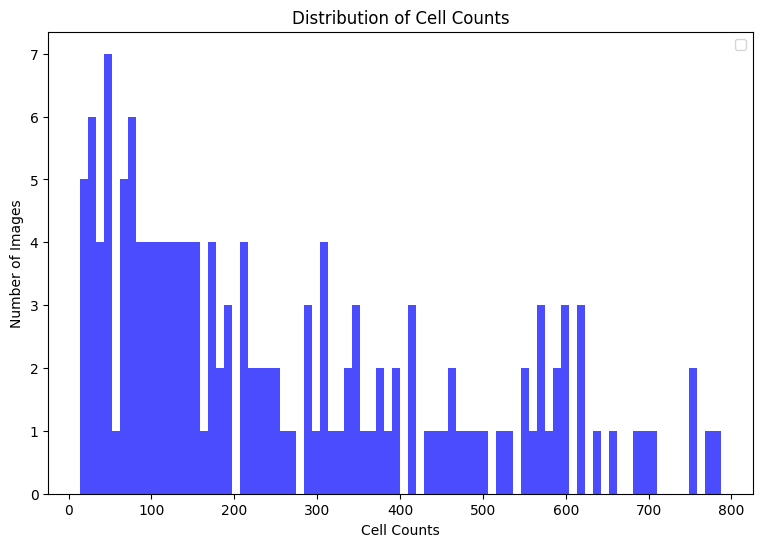

In [ ]:
# Create histograms
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
all_data = train_cell_counts + val_cell_counts + test_cell_counts


plt.hist(all_data, bins=80, density=False, alpha=0.7, color='blue')
#plt.hist(train_cell_counts, bins=60, density=False, alpha=0.7, color='red', label="Training")
#plt.hist(val_cell_counts, bins=60, density=False, alpha=0.7, color='orange', label="Validation")
#plt.hist(test_cell_counts, bins=60, density=False, alpha=0.7, color='green', label="Testing")
plt.title("Distribution of Cell Counts")
plt.xlabel("Cell Counts")
plt.ylabel("Number of Images")
plt.legend()


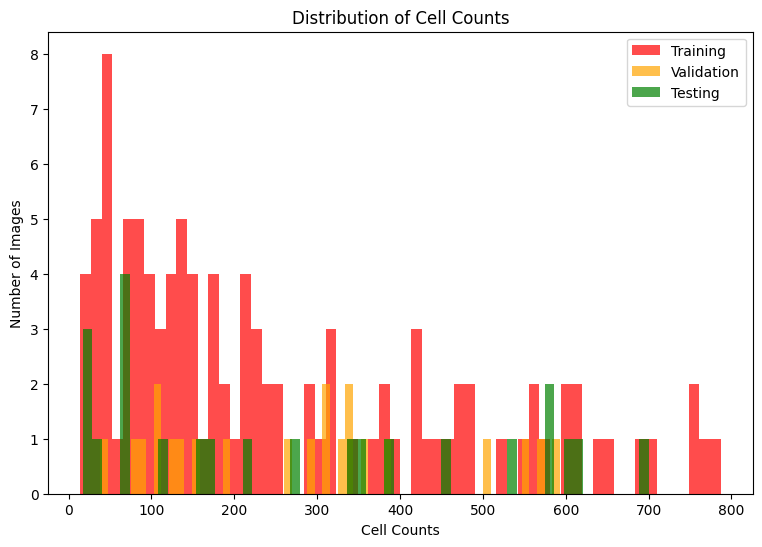

In [ ]:
# Create histograms
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

plt.hist(train_cell_counts, bins=60, density=False, alpha=0.7, color='red', label="Training")
plt.hist(val_cell_counts, bins=60, density=False, alpha=0.7, color='orange', label="Validation")
plt.hist(test_cell_counts, bins=60, density=False, alpha=0.7, color='green', label="Testing")
plt.title("Distribution of Cell Counts")
plt.xlabel("Cell Counts")
plt.ylabel("Number of Images")
plt.legend()

VGG16 Model

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class VGG16Regression(nn.Module):
    def __init__(self):
        super(VGG16Regression, self).__init__()
        # Load pre-trained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True).features

        # Freeze the pre-trained layers
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Custom layers for regression
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.vgg16(x)
        x = self.regressor(x)
        return x

# Instantiate the model
vgg16 = VGG16Regression()

loss_function = nn.MSELoss()
mae = nn.L1Loss()
optimizer = torch.optim.Adam(vgg16.regressor.parameters(), lr=0.001)



# def norm_mse(y_pred, y_true):
#     return torch.mean((((y_pred - y_true) ** 2)/y_pred))



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.7MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

# Lists to store metrics
train_losses = []
train_maes = []
val_losses = []
val_maes = []

# Early stopping parameters
early_stopping_patience = 10
epochs_no_improve = 0
min_val_loss = float('inf')

num_epochs = 500

for epoch in range(num_epochs):
    # Training Phase
    vgg16.train()
    running_loss = 0.0
    running_mae = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_mae += mae(outputs, targets).item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_mae = running_mae / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_maes.append(train_mae)

    # Validation Phase
    vgg16.eval()
    val_running_loss = 0.0
    val_running_mae = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.float().unsqueeze(1)

            outputs = vgg16(inputs)
            loss = loss_function(outputs, targets)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_mae += mae(outputs, targets).item() * inputs.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_mae = val_running_mae / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_maes.append(val_mae)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Loss: {train_loss:.4f} - '
          f'MAE: {train_mae:.4f} - '
          f'Val_Loss: {val_loss:.4f} - '
          f'Val_MAE: {val_mae:.4f}')


    # Early stopping check
    if val_loss < min_val_loss:
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f'Early stopping triggered after {epoch + 1} epochs!')
            break


Epoch [1/500], Loss: 109508.6898 - MAE: 253.8902 - Val_Loss: 97855.5469 - Val_MAE: 266.2654
Epoch [2/500], Loss: 101795.2053 - MAE: 239.2491 - Val_Loss: 88362.7891 - Val_MAE: 248.7051
Epoch [3/500], Loss: 93370.4711 - MAE: 222.5755 - Val_Loss: 77795.9922 - Val_MAE: 228.4900
Epoch [4/500], Loss: 82765.6601 - MAE: 203.6088 - Val_Loss: 66488.6719 - Val_MAE: 205.6579
Epoch [5/500], Loss: 72661.9499 - MAE: 186.4798 - Val_Loss: 54761.1992 - Val_MAE: 180.4779
Epoch [6/500], Loss: 61933.2574 - MAE: 171.1522 - Val_Loss: 43760.7891 - Val_MAE: 158.8138
Epoch [7/500], Loss: 54211.3536 - MAE: 162.1467 - Val_Loss: 34181.4727 - Val_MAE: 140.3611
Epoch [8/500], Loss: 45206.2037 - MAE: 153.7133 - Val_Loss: 27316.0059 - Val_MAE: 130.5354
Epoch [9/500], Loss: 40112.9605 - MAE: 153.0847 - Val_Loss: 22596.0352 - Val_MAE: 120.2059
Epoch [10/500], Loss: 37391.0868 - MAE: 156.9263 - Val_Loss: 20121.7070 - Val_MAE: 112.8467
Epoch [11/500], Loss: 35237.7717 - MAE: 158.4777 - Val_Loss: 19083.4316 - Val_MAE: 110.

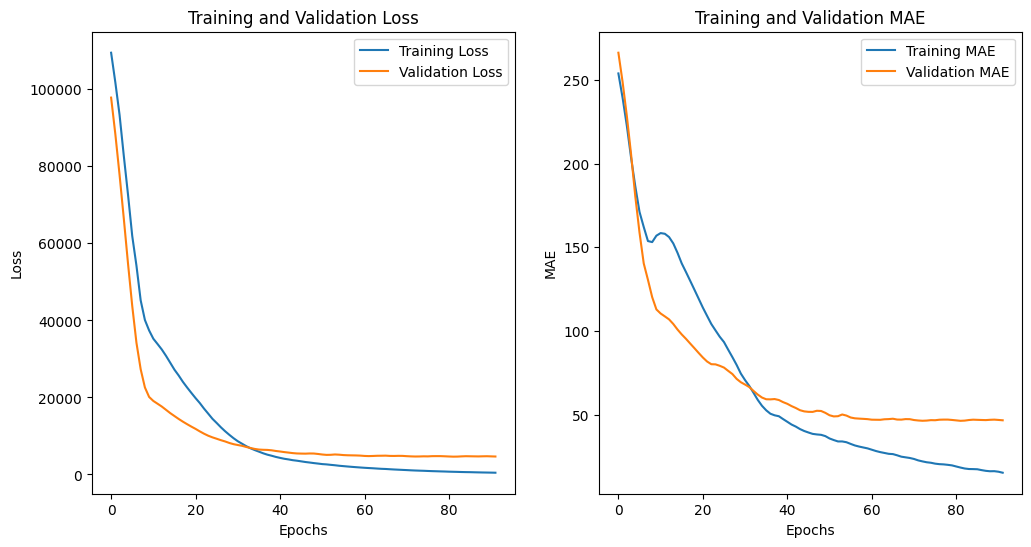

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(train_maes, label='Training MAE')
plt.plot(val_maes, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [ ]:

vgg16.eval()

# Initialize metrics
test_loss = 0.0
test_mae = 0.0

# No gradient updates needed
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.float().unsqueeze(1)

        # Forward pass
        outputs = vgg16(inputs)
        loss = loss_function(outputs, targets)

        # Update metrics
        test_loss += loss.item() * inputs.size(0)
        test_mae += mae(outputs, targets).item() * inputs.size(0)

# Calculate average loss and MAE
test_loss /= len(test_loader.dataset)
test_mae /= len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')


Test Loss: 3755.8364, Test MAE: 49.0347


In [ ]:
def calculate_acp(model, test_loader, device, threshold=0.05):
    model.eval()
    acp_counter = 0
    total_images = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.float().unsqueeze(1)
            outputs = model(inputs)
            absolute_diff = torch.abs(outputs - targets)
            within_threshold = absolute_diff <= (threshold * targets)

            acp_counter += torch.sum(within_threshold).item()
            total_images += targets.size(0)


    acp = acp_counter / total_images
    return acp

# Calculate ACP
acp = calculate_acp(vgg16, test_loader, device)
print(f"Accuracy within 5%: {acp * 100}%")


Accuracy within 5%: 4.3478260869565215%
